In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tabulate import tabulate
from random import random
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc,roc_curve
import pickle

In [2]:
import warnings 

warnings.filterwarnings("ignore") 

In [3]:
# Load data

train_path = 'dataset/Kaggle_Training_Dataset_v2.csv'
test_path = 'dataset/Kaggle_Test_Dataset_v2.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
train_data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

### Feature engineering for forecast and sales columns:

In [5]:
(((train_data['sales_1_month']>0)|(train_data['sales_3_month']>0)|(train_data['sales_6_month']>0)|(train_data['sales_9_month']>0))&(train_data['went_on_backorder'] =='Yes')).sum()/(train_data['went_on_backorder'] =='Yes').sum()

0.866023200212521

In [6]:
(((train_data['forecast_3_month']>0)|(train_data['forecast_6_month']>0)|(train_data['forecast_9_month']>0))&(train_data['went_on_backorder'] =='Yes')).sum()/(train_data['went_on_backorder'] =='Yes').sum()

0.9051624900380767

### Observations: 
> It can bee seen that for all 'Yes' backorders, more than 85% of the rows have either of the sales cols value > 0 <br>
> It can bee seen that for all 'Yes' backorders, more than 90% of the rows have either of the forecast cols value > 0

We can thus add a column 'sales' which will be 1 if either of the sales cols have a value > 0 else 0 <br>
We can thus add a column 'forecast' which will be 1 if either of the forecast cols have a value > 0 else 0

In [4]:
# Preprocessing as per EDA

# Dropping last row which is invalid data
# Removing rows where lead_time is nan
# Adding sales and forecast columns
# Remove sku column
# Perform OHE on categorical data
# Perfrom MinmaxScaler transform 

train_data.drop(train_data.tail(1).index,inplace=True)


train_data = train_data[train_data['lead_time'].notnull()]
lead_time_median = train_data['lead_time'].median()

   
train_data['forecast']=(train_data['forecast_3_month']>0)|(train_data['forecast_6_month']>0)|(train_data['forecast_9_month']>0)
train_data['forecast']=train_data['forecast'].astype(int)
train_data['sales']=(train_data['sales_1_month']>0)|(train_data['sales_3_month']>0)|(train_data['sales_6_month']>0)|(train_data['sales_9_month']>0)
train_data['sales']=train_data['sales'].astype(int)

remove_cols = ['sku']

train_data = train_data.drop(labels=remove_cols,axis=1)
train_data= pd.get_dummies(train_data,drop_first=True)
scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data_norm,columns=train_data.columns)

In [5]:
# Performing the same set of transformations on test data
# Instead of removing rows, filling missing values for lead_time with median lead_time of train data

test_data.drop(test_data.tail(1).index,inplace=True)

test_data['lead_time'].fillna(lead_time_median,inplace=True)
test_data['forecast']=(test_data['forecast_3_month']>0)|(test_data['forecast_6_month']>0)|(test_data['forecast_9_month']>0)
test_data['forecast']=test_data['forecast'].astype(int)
test_data['sales']=(test_data['sales_1_month']>0)|(test_data['sales_3_month']>0)|(test_data['sales_6_month']>0)|(test_data['sales_9_month']>0)
test_data['sales']=test_data['sales'].astype(int)

test_data = test_data.drop(labels=remove_cols,axis=1)
test_data= pd.get_dummies(test_data,drop_first=True)

# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Ensuring same set of columns for train and test
delta_cols = set(train_data.columns) - set(test_data.columns)

for c in delta_cols:
    test_data[c] = 0

test_data = test_data[train_data.columns]
test_data_norm = scaler.transform(test_data)
test_data = pd.DataFrame(test_data_norm,columns=test_data.columns)


In [6]:
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]

In [7]:
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    """
    Function to plot the confusion, precision and recall matrices
    """
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [12]:
# Calculation of F1 score on random weighted predictions as a baseline for evalation

maj_min_ratio = train_y.value_counts()[0]/(train_y.value_counts()[0]+train_y.value_counts()[1])
pred_base = np.zeros(shape=(len(test_y),1))
for i in range(len(test_y)):
    r = random()
    if r > maj_min_ratio: 
        pred_base[i]=1

f1_base = f1_score(test_y,pred_base)
print("Baseline F1 score with random ratio based predictions:",f1_base)

Baseline F1 score with random ratio based predictions: 0.010064043915827997


Test confusion_matrix for base predictor


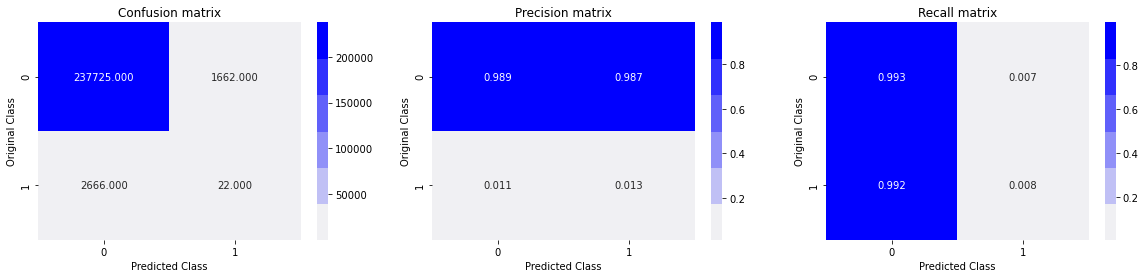

In [13]:
print('Test confusion_matrix for base predictor')
plot_confusion_matrix(test_y,pred_base)

#### Since there is very high class imbalance(> 130 times), to use SMOTE, we are first downsizing the majority class <br> to be 5 times of minority class and then perform SMOTE on it

In [10]:
train_x_rus, train_y_rus = RandomUnderSampler(0.2).fit_resample(train_x,train_y)

In [15]:
train_x.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,forecast,sales,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
0,0.002205,0.173077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.002205,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.002206,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.002205,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9900,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.002205,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Creating imblearn.pipelines which take care of sampling. <br> Here, we have done:
1. Over Sampling with SMOTE
2. Under Sampling with Random Under Sampling 

In [8]:
# https://stackoverflow.com/a/50245954/13254906

from imblearn.pipeline import Pipeline

smote_lr = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
    ])
smote_rf = Pipeline([
        ('sampling', SMOTE()),
        ('classification', RandomForestClassifier())
    ])
smote_xgb = Pipeline([
        ('sampling', SMOTE()),
        ('classification', XGBClassifier())
    ])
smote_svc = Pipeline([
        ('sampling', SMOTE()),
        ('classification', SVC(kernel='linear',max_iter=1000,probability=True))
    ])
smote_dt = Pipeline([
        ('sampling', SMOTE()),
        ('classification', DecisionTreeClassifier())
    ])
rus_lr = Pipeline([
        ('sampling', RandomUnderSampler()),
        ('classification', LogisticRegression())
    ])
rus_rf = Pipeline([
        ('sampling', RandomUnderSampler()),
        ('classification', RandomForestClassifier())
    ])
rus_xgb = Pipeline([
        ('sampling', RandomUnderSampler()),
        ('classification', XGBClassifier())
    ])
rus_svc = Pipeline([
        ('sampling', RandomUnderSampler()),
        ('classification', SVC(kernel='rbf',max_iter=1000,probability=True))
    ])
rus_dt = Pipeline([
        ('sampling', RandomUnderSampler()),
        ('classification', DecisionTreeClassifier())
    ])


imb_lr = LogisticRegression()
imb_rf = RandomForestClassifier()
imb_xgb = XGBClassifier()


In [9]:
# Creating params for Logistic Regression, Random Forest and XGB for GridSearchCV

lr_params = {'classification__C':[0.1,1,10]}
rf_params = {'classification__max_features':[12,'auto'],
                  'classification__n_estimators':[10,100,300]}
lr_imb_params = {'C':[0.1,1,10]}
rf_imb_params = {'max_features':[12,'auto'],
                  'n_estimators':[10,100,300]}
xgb_params = {'classification__eta':[0.01,0.1,0.3],
             'classification__max_depth':[3,7,10]}
svc_params = {'classification__C':[1,10]}             
dt_params = {'classification__max_depth':[2,5,10]}


#### Performing Grid Search with below model combinations: 
> Model 1: SMOTE Oversampling + Logistic Regression<br>
> Model 2: Random Under Sampling + Logistic Regression<br>
> Model 3: Imbalanced data + Logistic Regression<br>
> Model 4: SMOTE Oversampling + Random Forest<br>
> Model 5: Random Under Sampling + Random Forest<br>
> Model 6: Random Under Sampling + XGBoost Classifier<br>
> Model 7: Imbalanced data + XGBoost Classifier<br>
> Model 8: SMOTE Oversampling + XGBoost Classifier<br>
> Model 9: SMOTE Oversampling + SVC<br>
> Model 10: SMOTE Oversampling + Decision Tree<br>
> Model 11: Random Under Sampling + SVC<br>
> Model 12: Random Under Sampling + Decision Tree<br>

F1 Score for Smote-Logistic Regression on Train data: 0.4662254731220248
F1 Score for Smote-Logistic Regression on Test data: 0.04990577822947765
Train data confusion_matrix for Smote-Logistic Regression


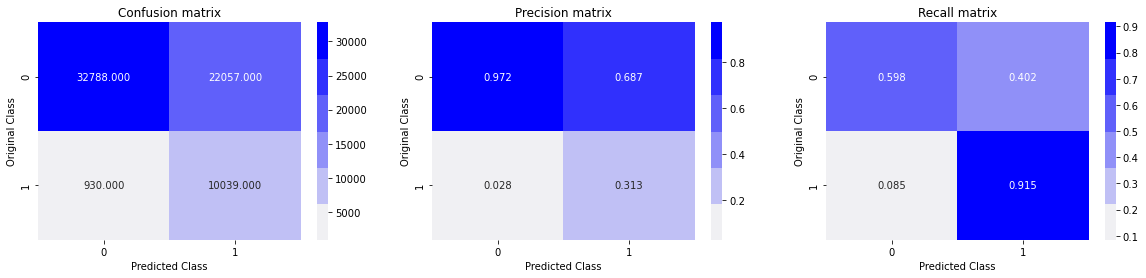

Test data confusion_matrix for Smote-Logistic Regression


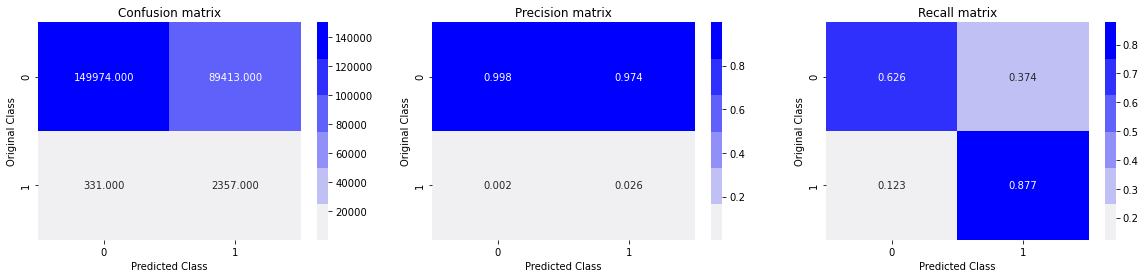

In [41]:
gcv_smote_lr = GridSearchCV(smote_lr,lr_params,scoring='f1',return_train_score=True)
gcv_smote_lr.fit(train_x_rus,train_y_rus)

print("F1 Score for Smote-Logistic Regression on Train data:",f1_score(train_y_rus,gcv_smote_lr.predict(train_x_rus)))
print("F1 Score for Smote-Logistic Regression on Test data:",f1_score(test_y,gcv_smote_lr.predict(test_x)))

print('Train data confusion_matrix for Smote-Logistic Regression')
plot_confusion_matrix(train_y_rus,gcv_smote_lr.predict(train_x_rus))
print('Test data confusion_matrix for Smote-Logistic Regression')
plot_confusion_matrix(test_y,gcv_smote_lr.predict(test_x))


F1 Score for RUS-Logistic Regression on Train data: 0.030651586220348852
F1 Score for RUS-Logistic Regression on Test data: 0.04970030233121596
Train data confusion_matrix for RUS-Logistic Regression


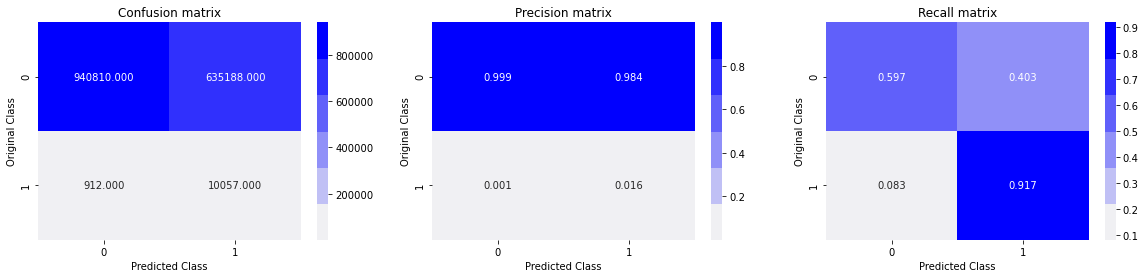

Test data confusion_matrix for RUS-Logistic Regression


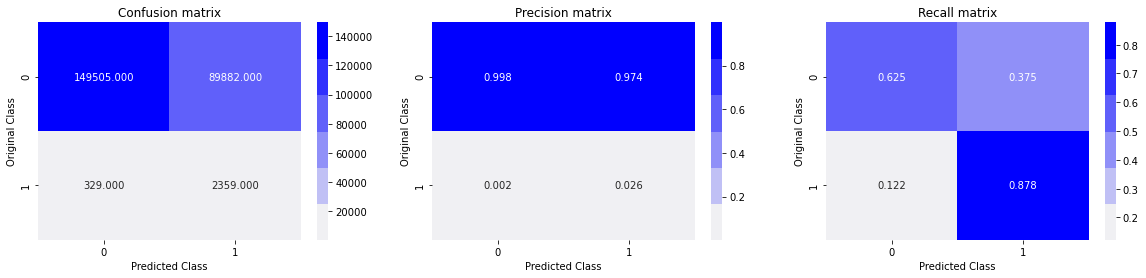

In [42]:
gcv_rus_lr = GridSearchCV(rus_lr,lr_params,scoring='f1',return_train_score=True)
gcv_rus_lr.fit(train_x,train_y)

print("F1 Score for RUS-Logistic Regression on Train data:",f1_score(train_y,gcv_rus_lr.predict(train_x)))
print("F1 Score for RUS-Logistic Regression on Test data:",f1_score(test_y,gcv_rus_lr.predict(test_x)))

print('Train data confusion_matrix for RUS-Logistic Regression')
plot_confusion_matrix(train_y,gcv_rus_lr.predict(train_x))
print('Test data confusion_matrix for RUS-Logistic Regression')
plot_confusion_matrix(test_y,gcv_rus_lr.predict(test_x))


F1 Score for Imbalanced-Logistic Regression on Train data: 0.0
F1 Score for Imbalanced-Logistic Regression on Test data: 0.0
Train data confusion_matrix for Imbalanced-Logistic Regression


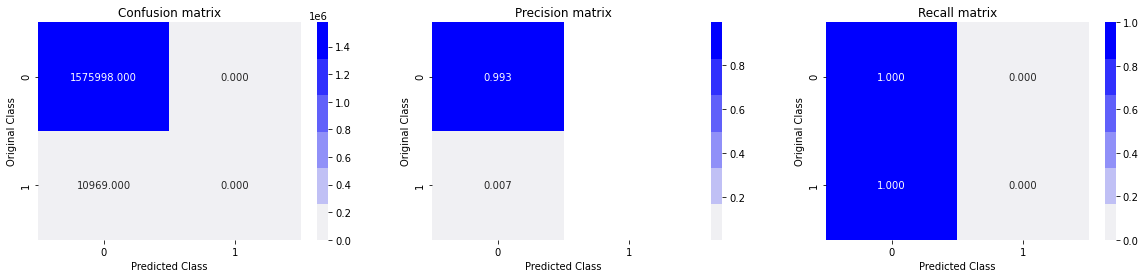

Test data confusion_matrix for Imbalanced-Logistic Regression


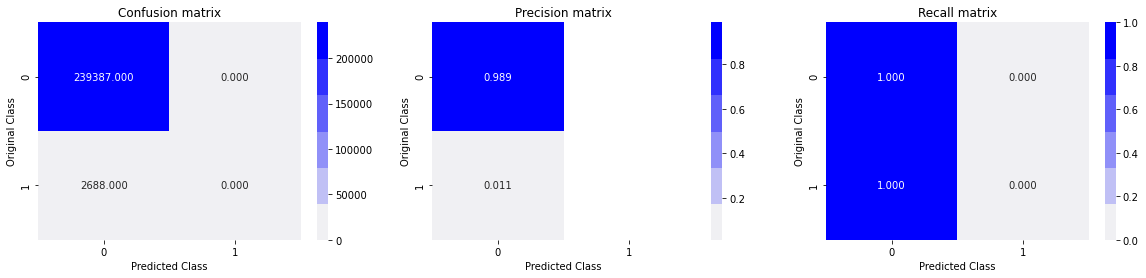

In [43]:
gcv_imb_lr = GridSearchCV(imb_lr,lr_imb_params,scoring='f1',return_train_score=True)
gcv_imb_lr.fit(train_x,train_y)

print("F1 Score for Imbalanced-Logistic Regression on Train data:",f1_score(train_y,gcv_imb_lr.predict(train_x)))
print("F1 Score for Imbalanced-Logistic Regression on Test data:",f1_score(test_y,gcv_imb_lr.predict(test_x)))

print('Train data confusion_matrix for Imbalanced-Logistic Regression')
plot_confusion_matrix(train_y,gcv_imb_lr.predict(train_x))
print('Test data confusion_matrix for Imbalanced-Logistic Regression')
plot_confusion_matrix(test_y,gcv_imb_lr.predict(test_x))


F1 Score for Smote-Random Forest on Train data: 0.9910925286311579
F1 Score for Smote-Random Forest on Test data: 0.2000876479058411
Train data confusion_matrix for Smote-Random Forest


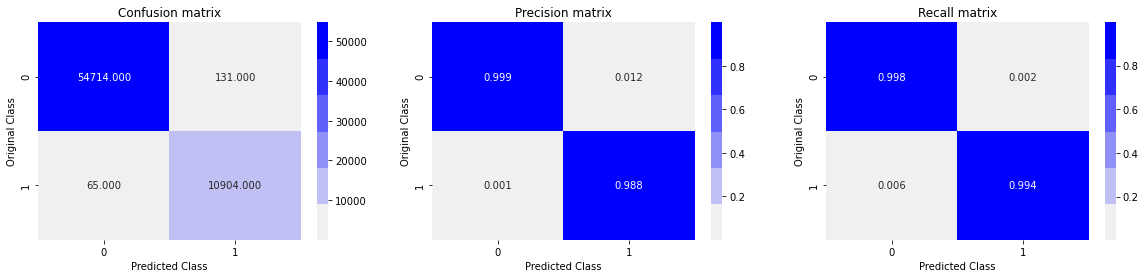

Test data confusion_matrix for Smote-Random Forest


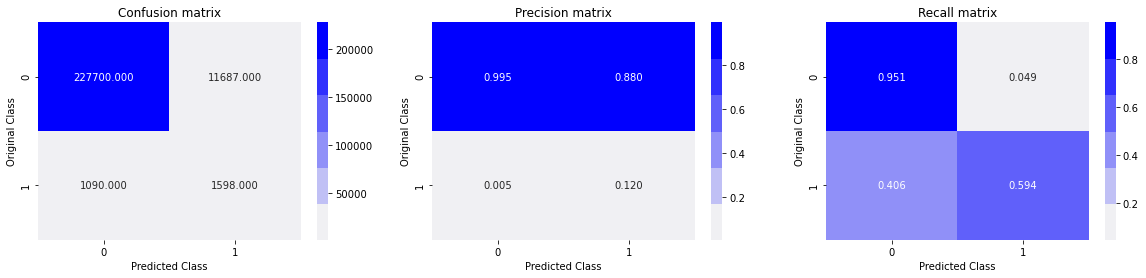

In [44]:
gcv_smote_rf = GridSearchCV(smote_rf,rf_params,scoring='f1',return_train_score=True)
gcv_smote_rf.fit(train_x_rus,train_y_rus)

print("F1 Score for Smote-Random Forest on Train data:",f1_score(train_y_rus,gcv_smote_rf.predict(train_x_rus)))
print("F1 Score for Smote-Random Forest on Test data:",f1_score(test_y,gcv_smote_rf.predict(test_x)))

print('Train data confusion_matrix for Smote-Random Forest')
plot_confusion_matrix(train_y_rus,gcv_smote_rf.predict(train_x_rus))
print('Test data confusion_matrix for Smote-Random Forest')
plot_confusion_matrix(test_y,gcv_smote_rf.predict(test_x))


F1 Score for RUS-Random Forest on Train data: 0.11030105150018758
F1 Score for RUS-Random Forest on Test data: 0.1413650021462298
Train data confusion_matrix for RUS-Random Forest


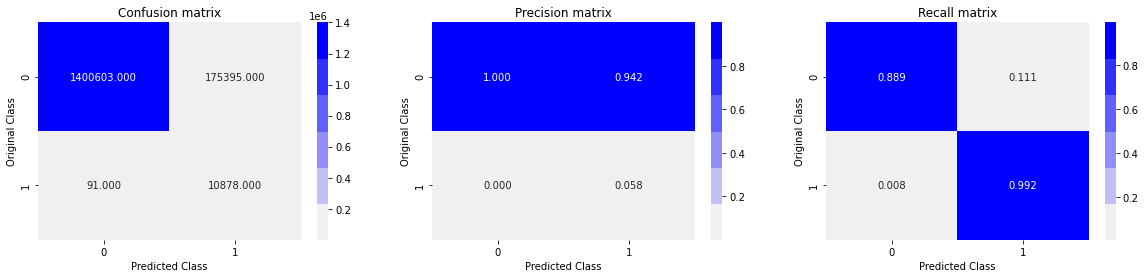

Test data confusion_matrix for RUS-Random Forest


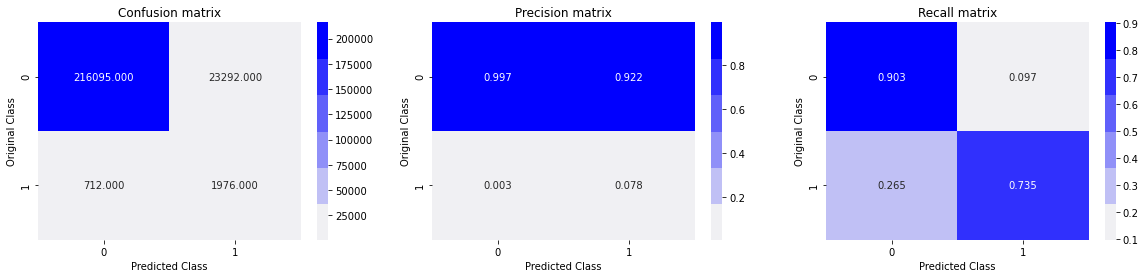

In [45]:
gcv_rus_rf = GridSearchCV(rus_rf,rf_params,scoring='f1',return_train_score=True)
gcv_rus_rf.fit(train_x,train_y)

print("F1 Score for RUS-Random Forest on Train data:",f1_score(train_y,gcv_rus_rf.predict(train_x)))
print("F1 Score for RUS-Random Forest on Test data:",f1_score(test_y,gcv_rus_rf.predict(test_x)))

print('Train data confusion_matrix for RUS-Random Forest')
plot_confusion_matrix(train_y,gcv_rus_rf.predict(train_x))
print('Test data confusion_matrix for RUS-Random Forest')
plot_confusion_matrix(test_y,gcv_rus_rf.predict(test_x))


[21:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

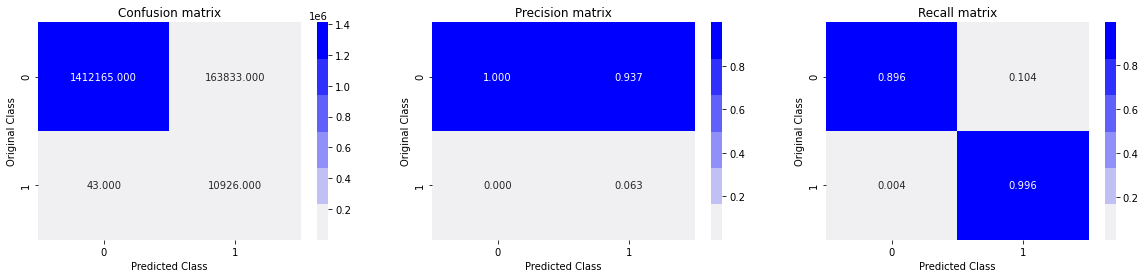

Test data confusion_matrix for RUS-XGB


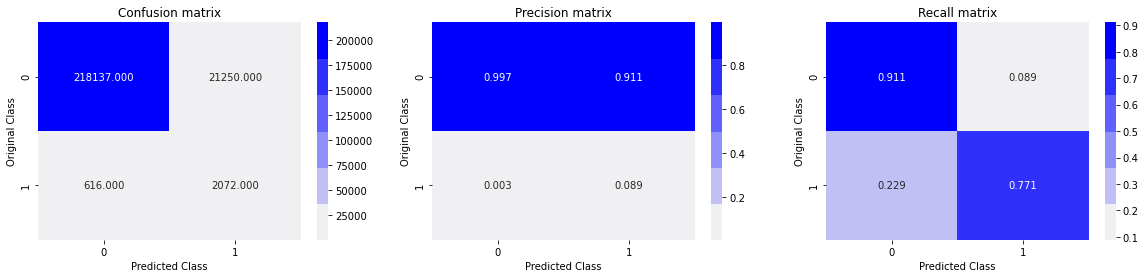

In [46]:
gcv_rus_xgb = GridSearchCV(rus_xgb,xgb_params,scoring='f1',return_train_score=True)
gcv_rus_xgb.fit(train_x,train_y)

print("F1 Score for RUS-XGB on Train data:",f1_score(train_y,gcv_rus_xgb.predict(train_x)))
print("F1 Score for RUS-XGB on Test data:",f1_score(test_y,gcv_rus_xgb.predict(test_x)))

print('Train data confusion_matrix for RUS-XGB')
plot_confusion_matrix(train_y,gcv_rus_xgb.predict(train_x))
print('Test data confusion_matrix for RUS-XGB')
plot_confusion_matrix(test_y,gcv_rus_xgb.predict(test_x))


[21:57:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "return_train_score", "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


F1 Score for IMB-XGB on Train data: 0.7283950617283951
F1 Score for IMB-XGB on Test data: 0.04761904761904762
Train data confusion_matrix for IMB-XGB


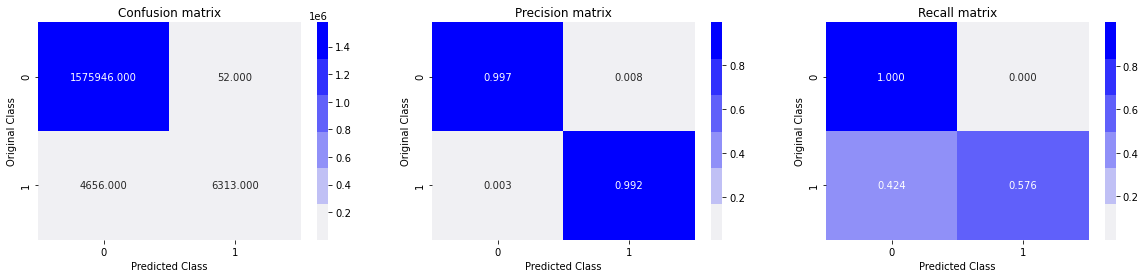

Test data confusion_matrix for IMB-XGB


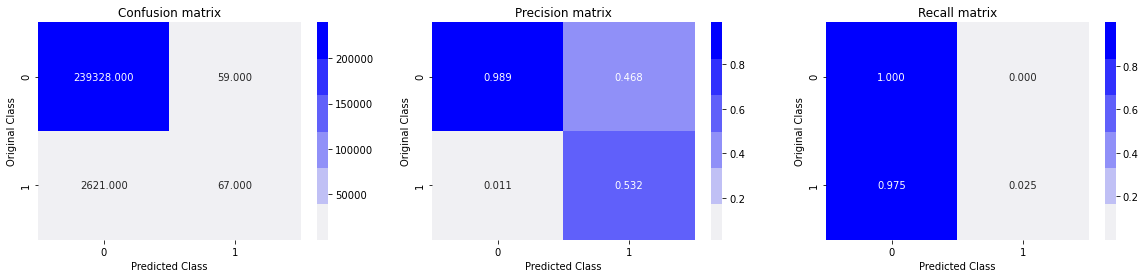

In [47]:
imb_xgb = XGBClassifier(eta=0.3,max_depth=10,scoring='f1',eval_metric='auc',return_train_score=True)
imb_xgb.fit(train_x,train_y)

print("F1 Score for IMB-XGB on Train data:",f1_score(train_y,imb_xgb.predict(train_x)))
print("F1 Score for IMB-XGB on Test data:",f1_score(test_y,imb_xgb.predict(test_x)))

print('Train data confusion_matrix for IMB-XGB')
plot_confusion_matrix(train_y,imb_xgb.predict(train_x))
print('Test data confusion_matrix for IMB-XGB')
plot_confusion_matrix(test_y,imb_xgb.predict(test_x))

[12:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

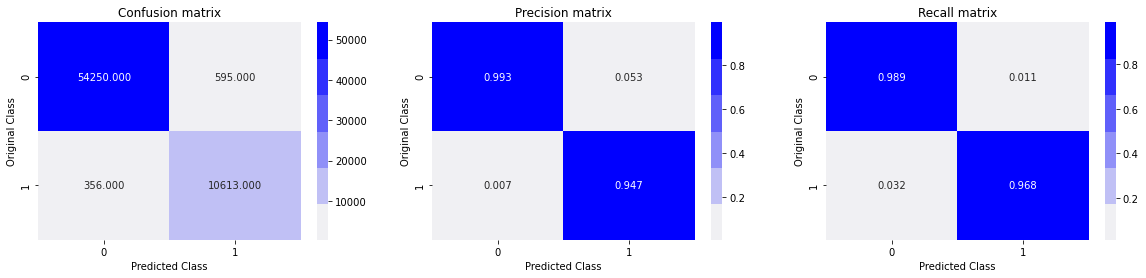

Test data confusion_matrix for Smote-XGB


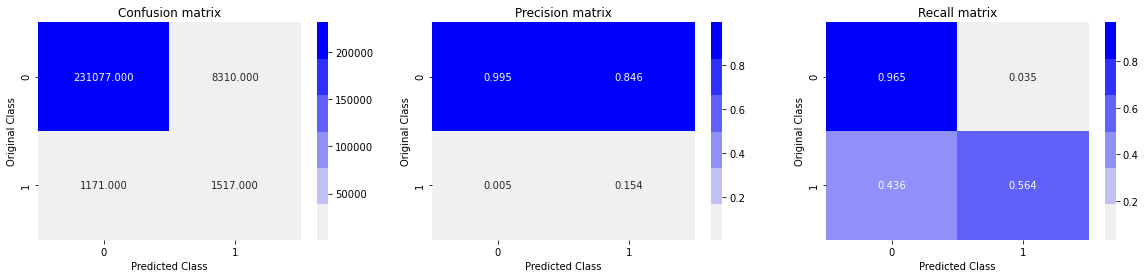

In [13]:
gcv_smote_xgb = GridSearchCV(smote_xgb,xgb_params,scoring='f1',return_train_score=True)
gcv_smote_xgb.fit(train_x_rus,train_y_rus)

print("F1 Score for Smote-XGB on Train data:",f1_score(train_y_rus,gcv_smote_xgb.predict(train_x_rus)))
print("F1 Score for Smote-XGB on Test data:",f1_score(test_y,gcv_smote_xgb.predict(test_x)))

print('Train data confusion_matrix for Smote-XGB')
plot_confusion_matrix(train_y_rus,gcv_smote_xgb.predict(train_x_rus))
print('Test data confusion_matrix for Smote-XGB')
plot_confusion_matrix(test_y,gcv_smote_xgb.predict(test_x))

F1 Score for Smote-SVC on Train data: 0.28356479940347
F1 Score for Smote-SVC on Test data: 0.02193785831764421
Train data confusion_matrix for Smote-SVC


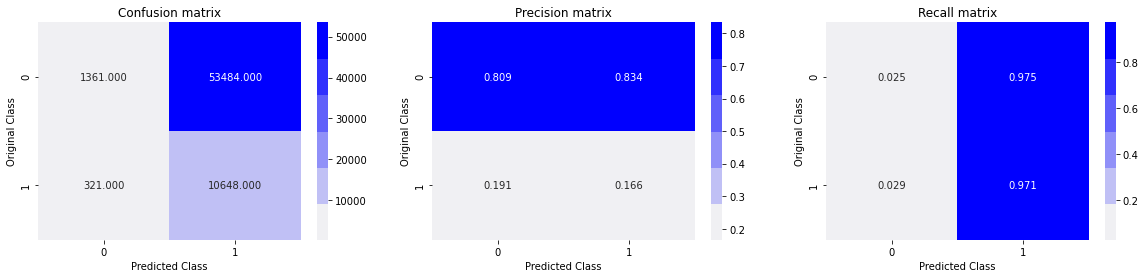

Test data confusion_matrix for Smote-SVC


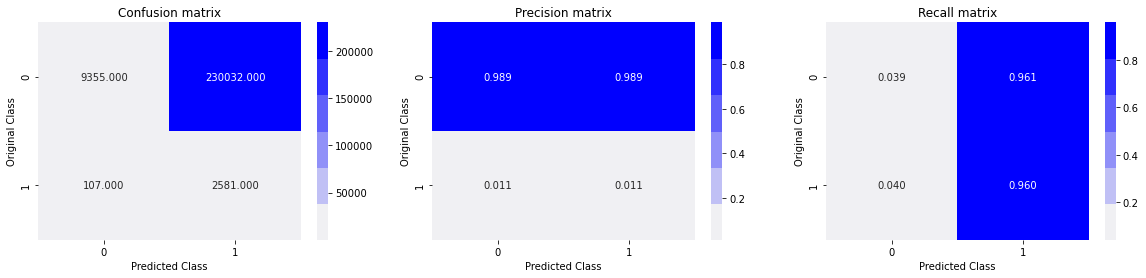

In [28]:
gcv_smote_svc = GridSearchCV(smote_svc,svc_params,scoring='f1',return_train_score=True)
gcv_smote_svc.fit(train_x_rus,train_y_rus)

print("F1 Score for Smote-SVC on Train data:",f1_score(train_y_rus,gcv_smote_svc.predict(train_x_rus)))
print("F1 Score for Smote-SVC on Test data:",f1_score(test_y,gcv_smote_svc.predict(test_x)))

print('Train data confusion_matrix for Smote-SVC')
plot_confusion_matrix(train_y_rus,gcv_smote_svc.predict(train_x_rus))
print('Test data confusion_matrix for Smote-SVC')
plot_confusion_matrix(test_y,gcv_smote_svc.predict(test_x))

F1 Score for Smote-DT on Train data: 0.6031054045983877
F1 Score for Smote-DT on Test data: 0.08039260684590534
Train data confusion_matrix for Smote-DT


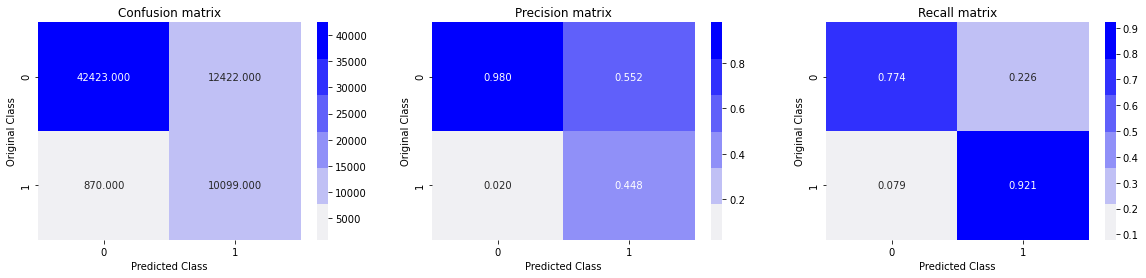

Test data confusion_matrix for Smote-DT


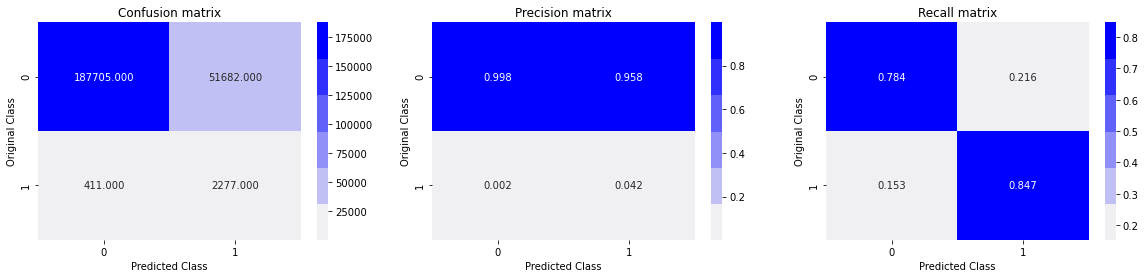

In [38]:
gcv_smote_dt = GridSearchCV(smote_dt,dt_params,scoring='f1',return_train_score=True)
gcv_smote_dt.fit(train_x_rus,train_y_rus)

print("F1 Score for Smote-DT on Train data:",f1_score(train_y_rus,gcv_smote_dt.predict(train_x_rus)))
print("F1 Score for Smote-DT on Test data:",f1_score(test_y,gcv_smote_dt.predict(test_x)))

print('Train data confusion_matrix for Smote-DT')
plot_confusion_matrix(train_y_rus,gcv_smote_dt.predict(train_x_rus))
print('Test data confusion_matrix for Smote-DT')
plot_confusion_matrix(test_y,gcv_smote_dt.predict(test_x))

F1 Score for RUS-SVC on Train data: 0.014303333938866633
F1 Score for RUS-SVC on Test data: 0.023563619019665392
Train data confusion_matrix for RUS-SVC


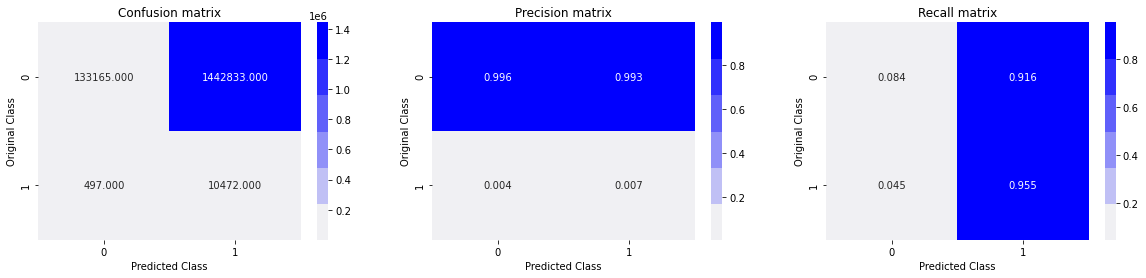

Test data confusion_matrix for RUS-SVC


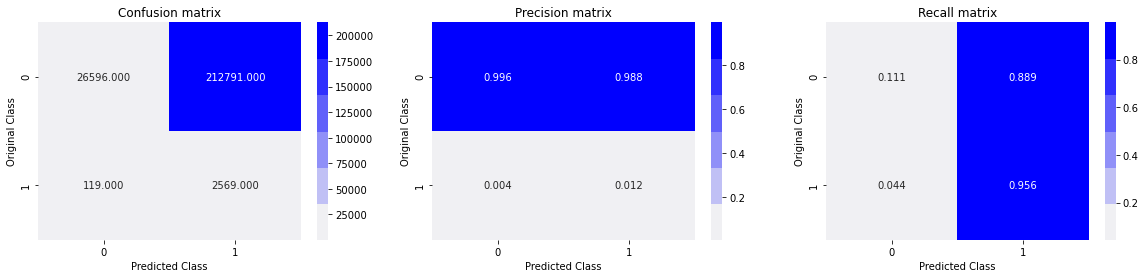

In [30]:
gcv_rus_svc = GridSearchCV(rus_svc,svc_params,scoring='f1',return_train_score=True)
gcv_rus_svc.fit(train_x,train_y)

print("F1 Score for RUS-SVC on Train data:",f1_score(train_y,gcv_rus_svc.predict(train_x)))
print("F1 Score for RUS-SVC on Test data:",f1_score(test_y,gcv_rus_svc.predict(test_x)))

print('Train data confusion_matrix for RUS-SVC')
plot_confusion_matrix(train_y,gcv_rus_svc.predict(train_x))
print('Test data confusion_matrix for RUS-SVC')
plot_confusion_matrix(test_y,gcv_rus_svc.predict(test_x))

F1 Score for RUS-DT on Train data: 0.06719460666899911
F1 Score for RUS-DT on Test data: 0.09933942504660852
Train data confusion_matrix for RUS-DT


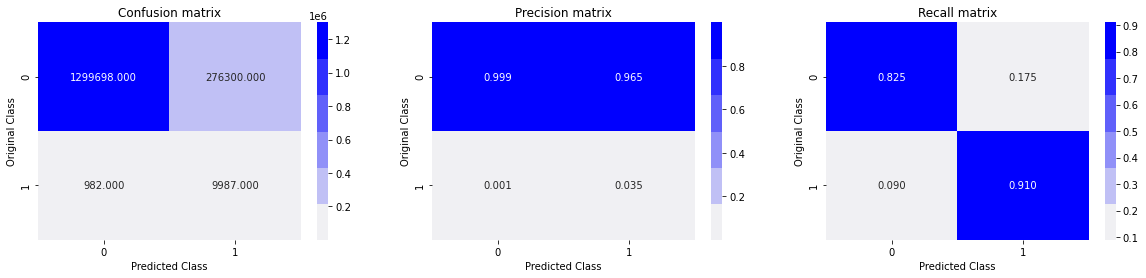

Test data confusion_matrix for RUS-DT


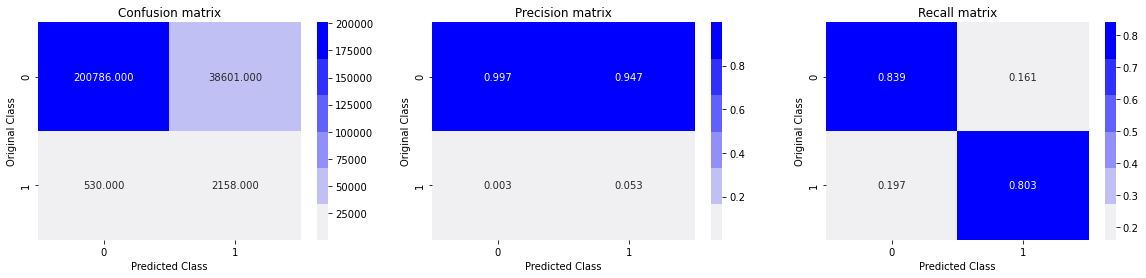

In [39]:
gcv_rus_dt = GridSearchCV(rus_dt,dt_params,scoring='f1',return_train_score=True)
gcv_rus_dt.fit(train_x,train_y)

print("F1 Score for RUS-DT on Train data:",f1_score(train_y,gcv_rus_dt.predict(train_x)))
print("F1 Score for RUS-DT on Test data:",f1_score(test_y,gcv_rus_dt.predict(test_x)))

print('Train data confusion_matrix for RUS-DT')
plot_confusion_matrix(train_y,gcv_rus_dt.predict(train_x))
print('Test data confusion_matrix for RUS-DT')
plot_confusion_matrix(test_y,gcv_rus_dt.predict(test_x))

F1 Score for RUS-RGB on Train data: 0.02077051926298157
F1 Score for RUS-RGB on Test data: 0.034108550613787314
Train data confusion_matrix for RUS-RGB


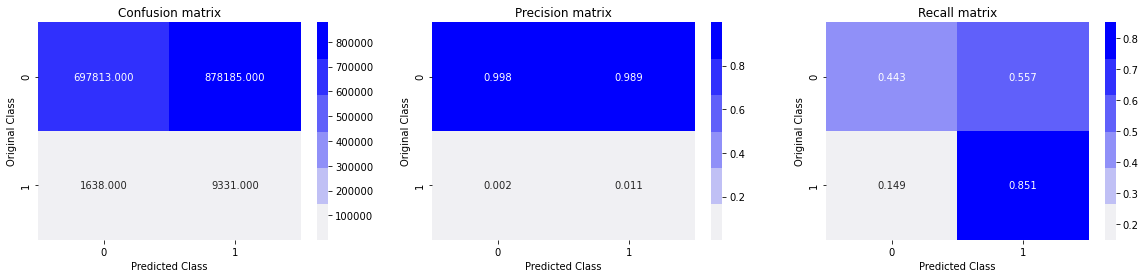

Test data confusion_matrix for RUS-RGB


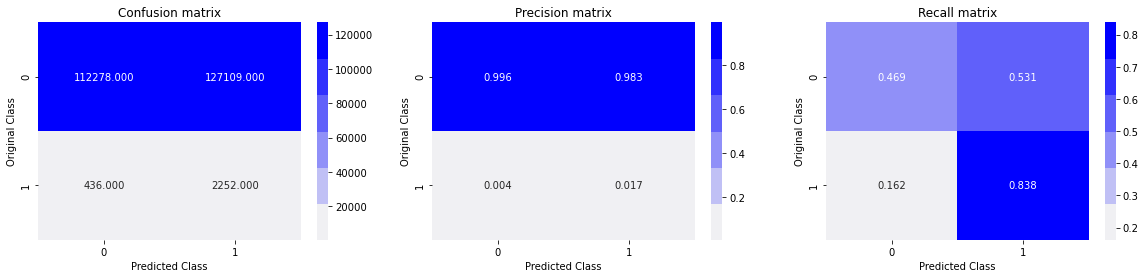

In [49]:
gcv_rus_rgb = SVC(max_iter=500,probability=True)
gcv_rus_rgb.fit(train_x,train_y)

print("F1 Score for RUS-RGB on Train data:",f1_score(train_y,gcv_rus_rgb.predict(train_x)))
print("F1 Score for RUS-RGB on Test data:",f1_score(test_y,gcv_rus_rgb.predict(test_x)))

print('Train data confusion_matrix for RUS-RGB')
plot_confusion_matrix(train_y,gcv_rus_rgb.predict(train_x))
print('Test data confusion_matrix for RUS-RGB')
plot_confusion_matrix(test_y,gcv_rus_rgb.predict(test_x))

In [50]:
print("Model 1 AUC:",roc_auc_score(test_y,gcv_smote_lr.predict_proba(test_x)[:,1]))
print("Model 2 AUC:",roc_auc_score(test_y,gcv_rus_lr.predict_proba(test_x)[:,1]))
print("Model 3 AUC:",roc_auc_score(test_y,gcv_imb_lr.predict_proba(test_x)[:,1]))
print("Model 4 AUC:",roc_auc_score(test_y,gcv_smote_rf.predict_proba(test_x)[:,1]))
print("Model 5 AUC:",roc_auc_score(test_y,gcv_rus_rf.predict_proba(test_x)[:,1]))
print("Model 6 AUC:",roc_auc_score(test_y,gcv_rus_xgb.predict_proba(test_x)[:,1]))
print("Model 7 AUC:",roc_auc_score(test_y,imb_xgb.predict_proba(test_x)[:,1]))
print("Model 8 AUC:",roc_auc_score(test_y,gcv_smote_xgb.predict_proba(test_x)[:,1]))
print("Model 9 AUC:",roc_auc_score(test_y,gcv_smote_svc.predict_proba(test_x)[:,1]))
print("Model 10 AUC:",roc_auc_score(test_y,gcv_smote_dt.predict_proba(test_x)[:,1]))
print("Model 11 AUC:",roc_auc_score(test_y,gcv_rus_svc.predict_proba(test_x)[:,1]))
print("Model 12 AUC:",roc_auc_score(test_y,gcv_rus_dt.predict_proba(test_x)[:,1]))
print("Model 13 AUC:",roc_auc_score(test_y,gcv_rus_rgb.predict_proba(test_x)[:,1]))

Model 1 AUC: 0.788312667360751
Model 2 AUC: 0.7895141566134594
Model 3 AUC: 0.7884761833461238
Model 4 AUC: 0.9106651250866052
Model 5 AUC: 0.9049575542228194
Model 6 AUC: 0.925320422827989
Model 7 AUC: 0.9209680704555505
Model 8 AUC: 0.9224314241451927
Model 9 AUC: 0.5420232842175561
Model 10 AUC: 0.8565260729749318
Model 11 AUC: 0.7195560837047184
Model 12 AUC: 0.8651594304323822
Model 13 AUC: 0.7058545691206926


In [ ]:
print("Top 5 features for SMOTE + RF:")
train_data.columns[np.argsort(gcv_smote_rf.best_estimator_._final_estimator.feature_importances_)[-5:]]

In [ ]:
print("Top 5 features for RUS + RF:")
train_data.columns[np.argsort(gcv_rus_rf.best_estimator_._final_estimator.feature_importances_)[-5:]]

In [ ]:
print("Top 5 features for RUS + XGB:")
train_data.columns[np.argsort(gcv_rus_xgb.best_estimator_._final_estimator.feature_importances_)[-5:]]

In [53]:
table = [["SMOTE(Oversampling)","Logistic Regression",roc_auc_score(test_y,gcv_smote_lr.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_smote_lr.predict(test_x))],
        ["Random Undersampling","Logistic Regression",roc_auc_score(test_y,gcv_rus_lr.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_lr.predict(test_x))],
        ["None(Imbalanced)","Logistic Regression",roc_auc_score(test_y,gcv_imb_lr.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_imb_lr.predict(test_x))],
        ["SMOTE(Oversampling)","Random Forest",roc_auc_score(test_y,gcv_smote_rf.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_smote_rf.predict(test_x))],
        ["Random Undersampling","Random Forest",roc_auc_score(test_y,gcv_rus_rf.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_rf.predict(test_x))],
        ["Random Undersampling","XGBoost",roc_auc_score(test_y,gcv_rus_xgb.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_xgb.predict(test_x))],
        ["None(Imbalanced)","Random Forest",roc_auc_score(test_y,imb_xgb.predict_proba(test_x)[:,1]),f1_score(test_y,imb_xgb.predict(test_x))],
        ["SMOTE(Oversampling)","XGBoost",roc_auc_score(test_y,gcv_smote_xgb.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_smote_xgb.predict(test_x))],
        ["SMOTE(Oversampling)","SVC",roc_auc_score(test_y,gcv_smote_svc.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_smote_svc.predict(test_x))],
        ["SMOTE(Oversampling)","DT",roc_auc_score(test_y,gcv_smote_dt.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_smote_dt.predict(test_x))],
        ["Random Undersampling","SVC",roc_auc_score(test_y,gcv_rus_svc.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_svc.predict(test_x))],
        ["Random Undersampling","DT",roc_auc_score(test_y,gcv_rus_dt.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_dt.predict(test_x))],
        ["Random Undersampling","SVC-RGB",roc_auc_score(test_y,gcv_rus_rgb.predict_proba(test_x)[:,1]),f1_score(test_y,gcv_rus_rgb.predict(test_x))]]
print(tabulate(table,headers=['Sampling','Classifier','AUC score','F1 score']))

Sampling              Classifier             AUC score    F1 score
--------------------  -------------------  -----------  ----------
SMOTE(Oversampling)   Logistic Regression     0.788313   0.0499058
Random Undersampling  Logistic Regression     0.789514   0.0497003
None(Imbalanced)      Logistic Regression     0.788476   0
SMOTE(Oversampling)   Random Forest           0.910665   0.200088
Random Undersampling  Random Forest           0.904958   0.141365
Random Undersampling  XGBoost                 0.92532    0.159323
None(Imbalanced)      Random Forest           0.920968   0.047619
SMOTE(Oversampling)   XGBoost                 0.922431   0.242191
SMOTE(Oversampling)   SVC                     0.542023   0.0219379
SMOTE(Oversampling)   DT                      0.856526   0.0803926
Random Undersampling  SVC                     0.719556   0.0235636
Random Undersampling  DT                      0.865159   0.0993394
Random Undersampling  SVC-RGB                 0.705855   0.0341086


In [56]:
print(gcv_smote_lr.best_params_)
print(gcv_smote_rf.best_params_)
print(gcv_smote_xgb.best_params_)
print(gcv_smote_dt.best_params_)

{'classification__C': 10}
{'classification__max_features': 12, 'classification__n_estimators': 300}
{'classification__eta': 0.3, 'classification__max_depth': 10}
{'classification__max_depth': 10}


In [14]:
for_test = {}
for_test['lead_time_median'] = lead_time_median
for_test['train_columns'] = train_data.columns
for_test['scaler'] = scaler
for_test['model'] = gcv_smote_xgb
with open(r"test.pickle", "wb") as output_file:
    pickle.dump(for_test, output_file)



#### Notes:
1. Various ratios were tried for Undersampling and Oversampling
2. Alongwith F1 score, we are also tracking AUC as research paper uses that
3. Our best F1 score and AUC has been achieved for SMOTE + XGBOOST combination with addition of 2 features
4. Our best AUC is near 92.5 whereas research paper has achieved 94+. 